# Sensitivity study on the nonlinear analysis' parameters
This Jupyter notebook investigates the effect of varying the parameters of MSC Natran's SOL 106 nonlinear analysis on the load-displacement diagram of a box beam structure under a bending load.

## Problem definition
### Geometry

In [9]:
AR = 9. # aspect ratio - b/w
w = 1e3 # width [mm]
b = AR*w # span [mm]
non_dimensional_height = 0.2 # h/w
h = w*non_dimensional_height # box height [mm]
non_dimensional_thickness = 1/50 # t/h
t = h*non_dimensional_thickness # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.1f} m\n- semispan: {b/2/1e3:.1f} m\n- height: {h/1e3:.1f} m\n- wall thickness: {t:.1f} mm')

Box beam dimensions:
- width: 1.0 m
- semispan: 4.5 m
- height: 0.2 m
- wall thickness: 4.0 mm


### Material

In [10]:
rho = 2780e-12 # density [ton/mm^3]
E = 73.1e3 # Young's modulus [MPa]
nu = 0.3 # Poisson's ratio

### Mesh and boundary conditions

In [11]:
from resources import box_beam_utils
element_size = 22 # [mm]
box_beam_bdf_input, nodes_id_array, edge_indices, _ = box_beam_utils.create_base_bdf_input(E, nu, rho, t, w, b, h, element_size)
print(box_beam_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]
  SPC1:    1

bdf.params
  PARAM    : 1

bdf.nodes
  GRID     : 42536

bdf.elements
  CQUAD4   : 42432

bdf.properties
  PSHELL   : 1

bdf.materials
  MAT1     : 1




subcase=0 already exists...skipping


### Load
Boundary conditions

In [12]:
constraint_set_id = 1
root_nodes_ids = list(nodes_id_array[0,0:-2])
box_beam_bdf_input.add_spc1(constraint_set_id, '123456', root_nodes_ids)
box_beam_bdf_input.create_subcases(0)
box_beam_bdf_input.case_control_deck.subcases[0].add_integer_type('SPC', constraint_set_id) # id of single-point constraint to apply

subcase=0 already exists...skipping


Define applied load.

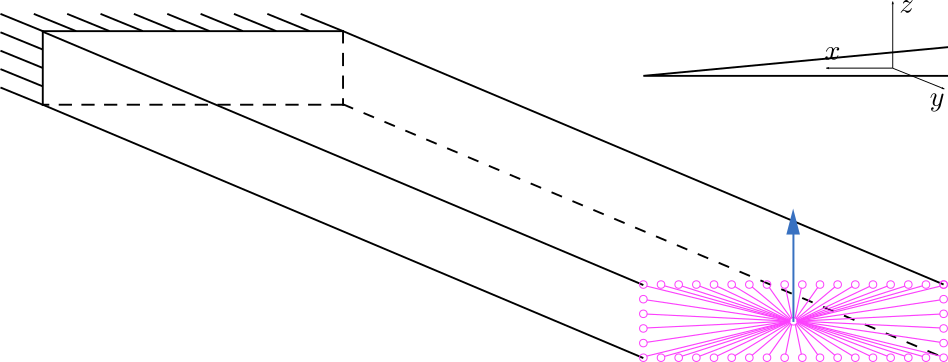

In [13]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [14]:
import numpy as np
# Add master node of tip section
master_node_id = np.amax(nodes_id_array)+1
box_beam_bdf_input.add_grid(master_node_id, [w/2, b/2, 0.])
# Add RBE2 element to make tip section rigid
rbe2_element_id = len(box_beam_bdf_input.elements)+1
tip_nodes_ids = list(nodes_id_array[-1,0:-2])
box_beam_bdf_input.add_rbe2(rbe2_element_id, master_node_id, '123456', tip_nodes_ids)
# Apply concentrated force to master node
force_set_id = constraint_set_id+1
force_magnitude = 1600. # [N]
force_direction = [0., 0., 1.]
box_beam_bdf_input.add_force(sid=force_set_id, node=master_node_id, mag=force_magnitude, xyz=force_direction)

# # Define id, magnitude and direction of the force cards
# force_set_id = constraint_set_id+1
# force_magnitude = 3800/nodes_id_array[:, 0:edge_indices[0]].size # [N]
# force_direction = [0., 0., 1.]
# # Add a force card for each node of the upper face
# for row in range(np.size(nodes_id_array, 0)):
#     for j in range(edge_indices[0]+1):
#         box_beam_bdf_input.add_force(sid=force_set_id, node=nodes_id_array[row, j], mag=force_magnitude, xyz=force_direction)

FORCE          2   42537           1600.      0.      0.      1.

Create subcase with applied load

In [15]:
from resources import pynastran_utils
first_subcase_id = 1
subcase_title = 'Apply static load'
pynastran_utils.create_static_load_subcase(box_beam_bdf_input, first_subcase_id, force_set_id)

## Nonlinear analysis

Set up nonlinear analysis solution sequence

In [16]:
# Assign solution sequence and analysis title
box_beam_bdf_input.sol = 106
box_beam_bdf_input.case_control_deck.subcases[0].add('TITLE', 'Nonlinear static analysis of a box beam', [], 'STRING-type')
# Add parameter for large displacement effects
box_beam_bdf_input.add_param('LGDISP', [1])
# Define general parameters for the nonlinear iteration strategy
nlparm_id = 1
box_beam_bdf_input.add_nlparm(nlparm_id=nlparm_id, kmethod='ITER', kstep=1, int_out='YES', conv='PW', eps_p=1e-2, eps_w=1e-2)
# Define parameters for the arc-length method
box_beam_bdf_input.add_nlpci(nlpci_id=nlparm_id, Type='CRIS', desiter=12, minalr=.25, maxalr=4.)
# Add NLPARM id to the control case commands
box_beam_bdf_input.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

Set up output files

In [17]:
# Add PARAM card to store results in a op2 file
box_beam_bdf_input.add_param('POST', [1])
# Set defaults for output files
box_beam_bdf_input.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type') # request neither sorted nor unsorted Bulk Data to be printed
box_beam_bdf_input.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT']) # store displacement data of all nodes in the op2 file
box_beam_bdf_input.case_control_deck.subcases[0].add_result_type('SPCFORCES', 'ALL', ['PLOT']) # store single point constraint forces data in the op2 file
box_beam_bdf_input.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT']) # store form and type of applied load vector

Define name of the analysis directory and of the input file.

In [18]:
import os
# Define name of analysis directory
analysis_directory_name = '05_Sensitivity_Study_Nonlinear_Analysis_Parameters'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Run analysis
input_filename = 'reference_analysis'

Define function to calculate the load-displacement diagram.

In [19]:
from pyNastran.op2.op2 import read_op2
import matplotlib.pyplot as plt

def calculate_load_displacement_diagram(directory_path, bdf_input, filename, load_component_index, node_id, displacement_component_index):
    # Run analysis
    pynastran_utils.run_analysis(directory_path, bdf_input, filename)
    # Read op2 output file
    op2_filepath = os.path.join(directory_path, filename + '.op2')
    op2_output = read_op2(op2_filepath, debug=False)
    # Save load and displacement data for each subcase
    load = {}
    disp = {}
    for subcase_id in op2_output.load_vectors:
        load[subcase_id] = np.apply_along_axis(np.sum, 1, op2_output.load_vectors[subcase_id].data[:, :, load_component_index])
        disp[subcase_id] = op2_output.displacements[subcase_id].data[:, node_id-1, displacement_component_index]
    # Return load and displacement variables
    return load, disp

Calculate and plot load-displacement diagram for the default nonlinear parameters.

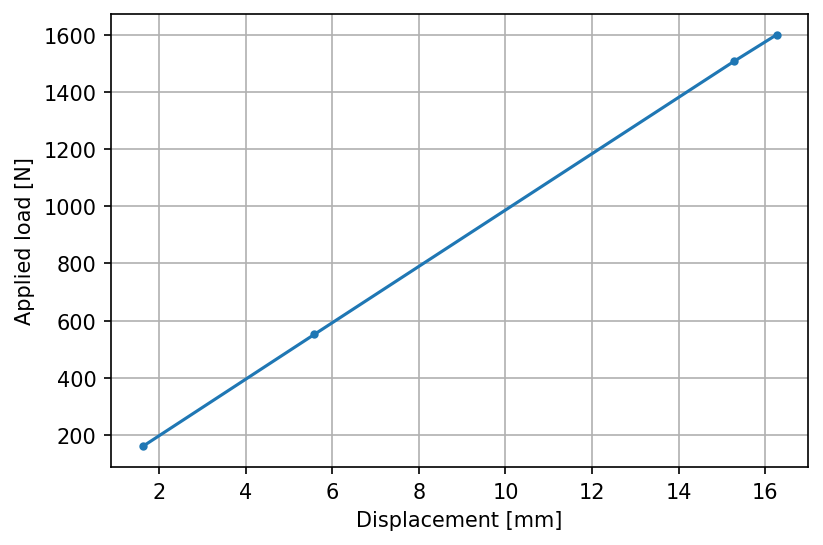

In [20]:
# Select translation along z as the load and displacmeent component to monitor
monitor_load_component_index = 2
monitor_node_id = nodes_id_array[-1,int(edge_indices[0]/2)]
monitor_displacement_component_index = 2
# Run analysis and return applied load and displacement
applied_load, displacement = calculate_load_displacement_diagram(analysis_directory_path, box_beam_bdf_input, input_filename, monitor_load_component_index, monitor_node_id, monitor_displacement_component_index)
# Set default dpi of figures
plt.rcParams['figure.dpi'] = 150
# Plot diagram
_, ax = plt.subplots()
ax.plot(displacement[first_subcase_id], applied_load[first_subcase_id], '.-')
plt.xlabel('Displacement [mm]')
plt.ylabel('Applied load [N]')
plt.grid()
plt.show()

## NLPARM fields
Variation of convergence tolerances.

In [21]:
# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

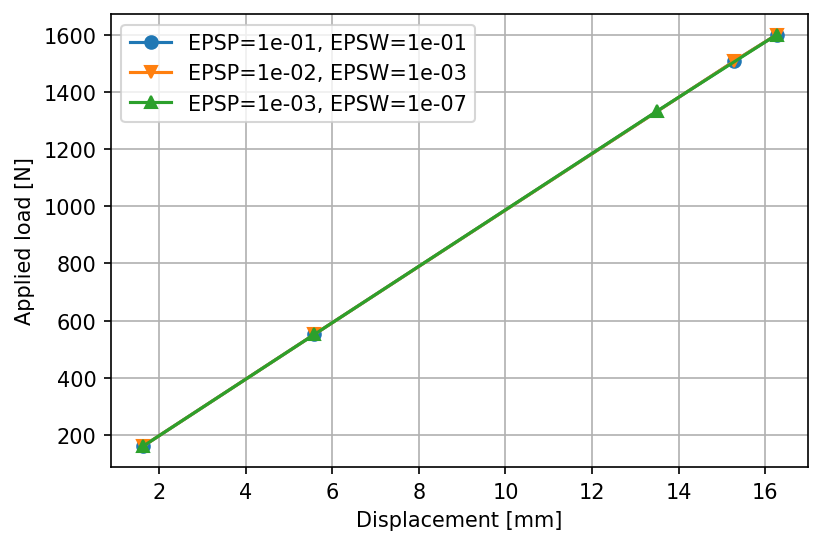

In [22]:
from matplotlib.lines import Line2D
# Get list of marker characters
markers = list(Line2D.markers.keys())[2:]
# Create figure
_, ax = plt.subplots()
# Run analysis for each couple of error tolerances and plot load-displacement diagram
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf_input.nlparms[nlparm_id].eps_p = epsp
    box_beam_bdf_input.nlparms[nlparm_id].eps_w = epsw
    input_filename = 'convergence_tolerance_analysis'
    applied_load, displacement = calculate_load_displacement_diagram(analysis_directory_path, box_beam_bdf_input, input_filename, monitor_load_component_index, monitor_node_id, monitor_displacement_component_index)
    ax.plot(displacement[first_subcase_id], applied_load[first_subcase_id], marker = markers[count], linestyle='-', label=f'EPSP={epsp:.0e}, EPSW={epsw:.0e}')
# Set axes label, legend and grid
plt.xlabel('Displacement [mm]')
plt.ylabel('Applied load [N]')
plt.legend()
plt.grid()
plt.show()

Variation of error functions.

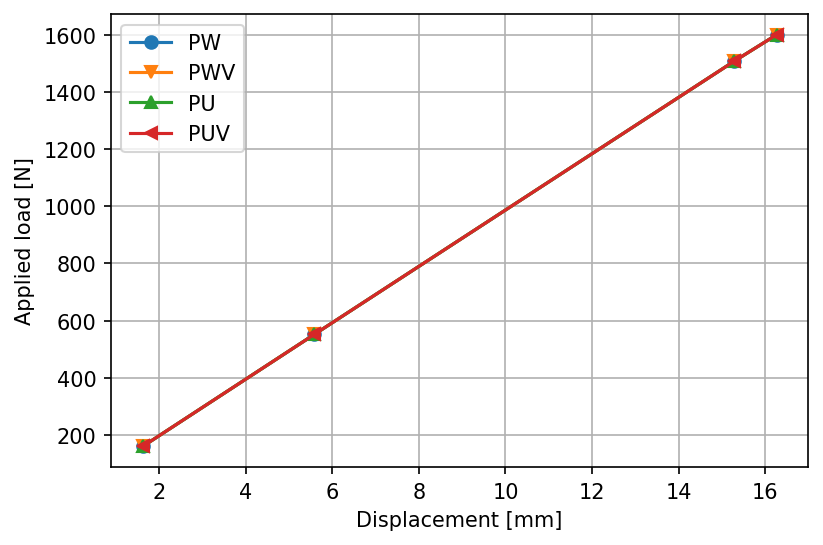

In [23]:
error_functions = ['PW', 'PWV', 'PU', 'PUV']
box_beam_bdf_input.nlparms[nlparm_id].eps_p = 1e-2
box_beam_bdf_input.nlparms[nlparm_id].eps_w = 1e-2
# Create figure
_, ax = plt.subplots()
# Run analysis for each couple of error tolerances and plot load-displacement diagram
for count, fun in enumerate(error_functions):
    box_beam_bdf_input.nlparms[nlparm_id].conv = fun
    input_filename = 'error_function_analysis'
    applied_load, displacement = calculate_load_displacement_diagram(analysis_directory_path, box_beam_bdf_input, input_filename, monitor_load_component_index, monitor_node_id, monitor_displacement_component_index)
    ax.plot(displacement[first_subcase_id], applied_load[first_subcase_id], marker = markers[count], linestyle='-', label=f'{fun}')
# Set axes label, legend and grid
plt.xlabel('Displacement [mm]')
plt.ylabel('Applied load [N]')
plt.legend()
plt.grid()
plt.show()

Variation of initial load increment.

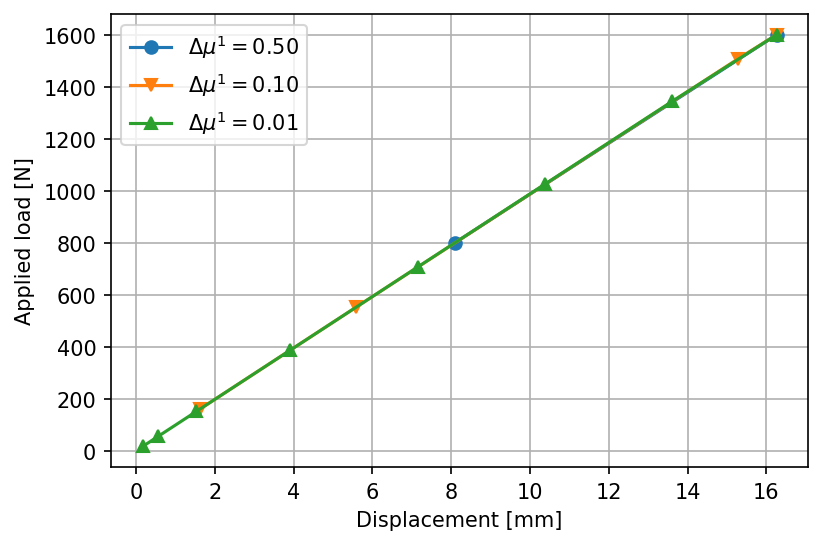

In [24]:
# Reset error function to default
box_beam_bdf_input.nlparms[nlparm_id].conv = 'PW'
# Define initial load increments
initial_load_increments = [.5, .1, .01]
# Create figure
_, ax = plt.subplots()
# Run analysis for each initial load increment and plot load-displacement diagram
for count, delta_mu_1 in enumerate(initial_load_increments):
    box_beam_bdf_input.nlparms[nlparm_id].ninc = int(1/delta_mu_1)
    input_filename = 'initial_load_increment_analysis'
    applied_load, displacement = calculate_load_displacement_diagram(analysis_directory_path, box_beam_bdf_input, input_filename, monitor_load_component_index, monitor_node_id, monitor_displacement_component_index)
    ax.plot(displacement[first_subcase_id], applied_load[first_subcase_id], marker = markers[count], linestyle='-', label=f'$\Delta\mu^1={delta_mu_1:.2f}$')
# Set axes label, legend and grid
plt.xlabel('Displacement [mm]')
plt.ylabel('Applied load [N]')
plt.legend()
plt.grid()
plt.show()

## NLPCI fields
Variation of desired number of iterations.

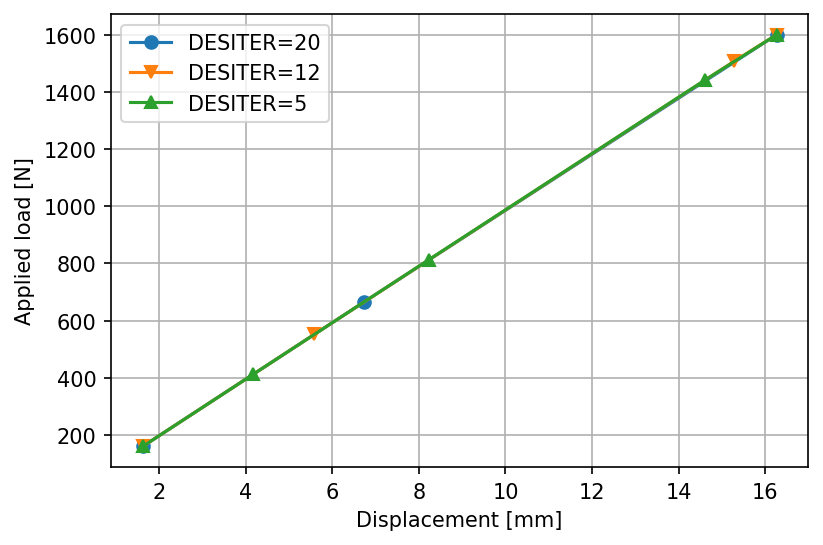

In [25]:
# Reset default number of increments
box_beam_bdf_input.nlparms[nlparm_id].ninc = 10
# Define desired numbers of iterations
no_iterations = [20, 12, 5]
# Create figure
_, ax = plt.subplots()
# Run analysis for each initial load increment and plot load-displacement diagram
for count, desiter in enumerate(no_iterations):
    box_beam_bdf_input.nlpcis[nlparm_id].desiter = desiter
    input_filename = 'desiter_analysis'
    applied_load, displacement = calculate_load_displacement_diagram(analysis_directory_path, box_beam_bdf_input, input_filename, monitor_load_component_index, monitor_node_id, monitor_displacement_component_index)
    ax.plot(displacement[first_subcase_id], applied_load[first_subcase_id], marker = markers[count], linestyle='-', label=f'DESITER={desiter}')
# Set axes label, legend and grid
plt.xlabel('Displacement [mm]')
plt.ylabel('Applied load [N]')
plt.legend()
plt.grid()
plt.show()

Variation of minimum allowable arc-length adjustment ratio.

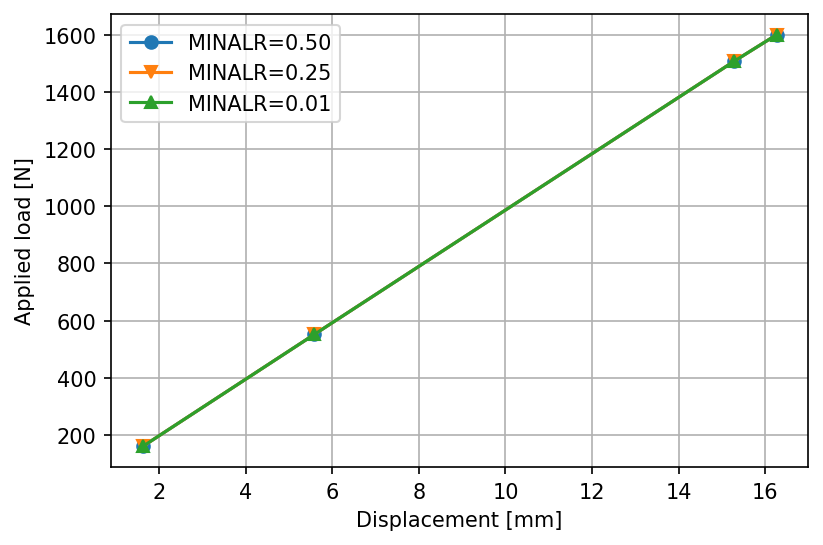

In [26]:
# Reset default desired number of iterations
box_beam_bdf_input.nlpcis[nlparm_id].desiter = 12
# Define minimum allowable arc-length adjustment ratios
min_arclength_adjustment_ratios = [.5, .25, .01]
# Create figure
_, ax = plt.subplots()
# Run analysis for each initial load increment and plot load-displacement diagram
for count, minalr in enumerate(min_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].minalr = minalr
    input_filename = 'minalr_analysis'
    applied_load, displacement = calculate_load_displacement_diagram(analysis_directory_path, box_beam_bdf_input, input_filename, monitor_load_component_index, monitor_node_id, monitor_displacement_component_index)
    ax.plot(displacement[first_subcase_id], applied_load[first_subcase_id], marker = markers[count], linestyle='-', label=f'MINALR={minalr:.2f}')
# Set axes label, legend and grid
plt.xlabel('Displacement [mm]')
plt.ylabel('Applied load [N]')
plt.legend()
plt.grid()
plt.show()

Variation of maximum allowable arc-length adjustment ratio.

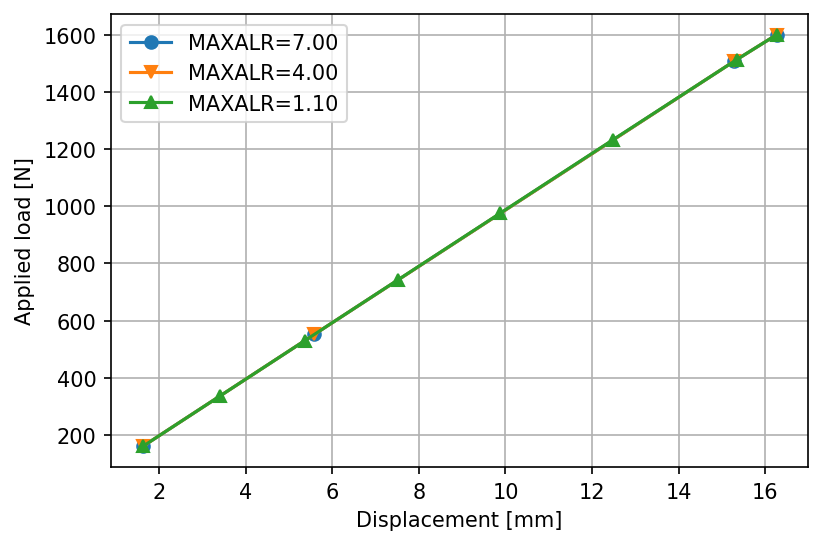

In [27]:
# Reset default minimum allowable arc-length adjustment ratio
box_beam_bdf_input.nlpcis[nlparm_id].minalr = .25
# Define maximum allowable arc-length adjustment ratios
max_arclength_adjustment_ratios = [7., 4., 1.1]
# Create figure
_, ax = plt.subplots()
# Run analysis for each initial load increment and plot load-displacement diagram
for count, maxalr in enumerate(max_arclength_adjustment_ratios):
    box_beam_bdf_input.nlpcis[nlparm_id].maxalr = maxalr
    input_filename = 'maxalr_analysis'
    applied_load, displacement = calculate_load_displacement_diagram(analysis_directory_path, box_beam_bdf_input, input_filename, monitor_load_component_index, monitor_node_id, monitor_displacement_component_index)
    ax.plot(displacement[first_subcase_id], applied_load[first_subcase_id], marker = markers[count], linestyle='-', label=f'MAXALR={maxalr:.2f}')
# Set axes label, legend and grid
plt.xlabel('Displacement [mm]')
plt.ylabel('Applied load [N]')
plt.legend()
plt.grid()
plt.show()